In [2]:
import os
import sys
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

module_dir = os.path.abspath('../../pynextsw/')  # Adjust path as needed
sys.path.append(module_dir)

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from functools import reduce
import numpy.testing as npt
from operator import itemgetter, attrgetter
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
pd.options.display.float_format = '{:.2g}'.format

2025-01-03 14:03:39
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from pynext.system_of_units import *

In [4]:
import pynext.pynext_types as pn
from pynext.CylinderGeomEff import barrel_detection_efficiency

In [42]:

    
def set_fonts(ax, fontsize=20):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)

def plotxy(xx, yy, xl, yl, tit, color='r', label="", figsize=(6,4)):
    fig, axs = plt.subplots(1, 1, figsize=figsize)
    axs.plot(xx, yy, color, label=label)
    axs.legend()
    axs.grid()
    axs.set_title(tit)
    axs.set_xlabel(xl)
    axs.set_ylabel(yl)
    fig.tight_layout()


# Paths to HD/BOLD Detectors

JJ, NEXT-CM, January 2025

## HD Design Drivers

- **Physics**

    - Best possible energy resolution (imply best possible calibration)
    - Performance of topological signature (physics, diffusion, pitch).
    
- **Radiopurity** 
    - Dominated by copper
    - Minimize radioactive budget inside the copper shield. 
    
- **BOLD constrains**
    - Use of TPB disfavoured (Is there a quantitative argument?)

- **Practical**
    - Cost & Complexity
    - Expanding collaboration 
    


## Baseline HD (BHD) design 

- TPB allowed. 

- Operating conditions: T = 20 C, P= 15-20 bar. 

- Tracking plane. Can be sparse (**STP**) o dense (**DTP**). 
    - Both STP and DTP can perform the tracking function. 
    - DTP can measure energy (and S1) better than STP.

- Barrel Fiber Detector (**BFD**) readout by cooled SiPMs.  
    - BFD can measure energy and S1. 



## Ultra Violet HD (UVHD)

- No TPB allowed. This leads naturally to a detector based on "VUV SiPMs" (**vSiPMs**).

- The most feasible option is a detector with two DTPs (one per anode) which perform tracking, measure the energy and measure S1.  


## Dark Current considerations

- Let us examine first the dependence of the dark current, DC (expressed as a dark rate) of SiPMs with temperature.
- We take as model the modern, low DC, Hamamatsu data S13360 series


In [50]:
xx = np.arange(-100, 20, 0.1)
yy = pn.logdc_vs_t(xx)


# Plot data and fitted line
def plot_dc():
    fig, axs = plt.subplots(1, 1, figsize=(6,4))
    axs.scatter(pn.tC, pn.ldR, label='Data')
    axs.plot(pn.tC, pn.y_fit, 'r-', label='Fitted line')
    axs.plot(xx, yy, 'g-', label='log(dc)')
    axs.legend()
    axs.grid()
    axs.set_title("Dependence of DC with Temperature (Hamamatsu S13360 series)")
    axs.set_xlabel("T (C)")
    axs.set_ylabel("log(dC) in kHz")
    fig.tight_layout()


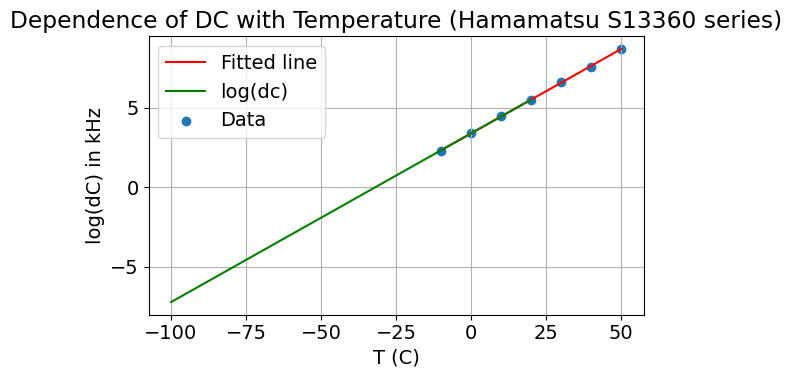

In [51]:
plot_dc()

## Operating temperature and pressure

- For this discussion I will assume that HD operated at P=20 bar, T= 20C. Notice that the density of the gas in this case is the same than when operating the detector at P=15 bar, T=-40C.  
- At P=20 bar, T= 20C, a detector of R= 110 cm and L/2 = 110 cm (e.g, the length of one of the two symmetric TPCs) has a total mass of 1040 kg
- With these dimensions, the area to be instrumented is 3.8 m$^2$ per DSP, that is a total of 7.6 m$^2$, e.g., almost twice the area required by nEXO. 

In [27]:
Rg   = 110 * cm
zmin = -110 * cm
zmax = 110 * cm
cl = pn.Cylinder(Rg, zmin, zmax)
hdxe = pn.TpcXe(cl, "xe_2020")
print(hdxe)
print(f"area of barrel = {hdxe.cyl.area_barrel/m2:.2f} m2")
print(f"area of end-caps = {hdxe.cyl.area_endcap/m2:.2f} m2")



        Configuration  = xe_2020
        density (rho)  =    0.12 g/cm3
        mass           = 1039.51  kg
        Cylinder       = 
        Cylinder: radius =1100.0 mm, length = 2200.0 mm
        
    
area of barrel = 15.21 m2
area of end-caps = 3.80 m2


## EL Parameters
- A higher pressure (density) is is enough with E/P ~1.5 to achieve an amplification gain ~1000. 
- The high voltages are challenging (~15 kV in the grid and 75 kV in the cathode), but can presumably be achieved, with enough R&D

In [28]:
EP  = 1.5 * kilovolt / (cm * bar)
dV  = 0.5 * kilovolt / cm
P   =  20 * bar
d   =  5 * mm
L   = 120 * cm
Ws  =  39.2 * eV
Wi  =  21.9 * eV
hdel = pn.TpcEL(EP, dV, P, d, L, Ws, Wi)
hdel


        E/P =    1.50 kV * cm^-1* bar^-1
        dV = drift voltage =    0.50 kV * cm^-1
        P  = pressure =   20.00 bar
        d  = EL grid gap =    5.00 mm
        L  = drift lenght =   1.20 m
        Grid voltage =   15.00 kV
        Cathode voltage =   75.00 kV
        Yield =  9.40e+02 photons/e

    
        Primary scintillation photons per MeV = 2.55e+04
        Primary ionization electrons per MeV = 4.57e+04
        EL photons per MeV                   = 4.29e+07
        
        Primary scintillation Krypton = 1.06e+03
        Primary ionization electrons Krypton = 1.89e+03
        EL photons Krypton                   = 1.78e+06
        
        Primary scintillation Qbb = 6.27e+04
        Primary ionization electrons Qbb = 1.12e+05
        EL photons Qbb                   = 1.06e+08
        

## Cooling the SiPMs in VUVHD

- The number of SiPMs in VUVHD is ~$3.8 \times 10^4$~per DSP plane, assuming that the detector is fully tiled. Assuming 2 mW per channel for the readout ASIC the dissipated power is 152 W (to compare with 100 W design specs for nEXO).

- At the same time, the SiPMs need to operate at low temperature to reduce dcR to reasonsable values. Ideally one would like to see the Krypton S1 signal, in particular in the case of a DTP with filling factor substantially less than one, for calibration purposes. If this is not possible, one should see at least the signal from Na-22 sources (511 keV).  


## The DTP
- We will consider first a DTP fully tiling up the anode(s), made of vSiPMs of 10 x 10 mm2 at a pitch of 10 mm. The PDE corresponds to the last generation of Hamamatsu SiPMs (PDE = 30 %). 
- The DTP has 3.8 x 10$^4$ SiPMs per Plane covering an area of 3.8 x 10$^6$ mm2. 
- The DC at t = -40 C is 91 counts per window of 500 ns (S1 detection window) and per DTP. At -30 C DC is 261 counts per plane and at T=-20 is 757 counts per plane.
- A rough estimation of the geometrical efficiency (neglecting reflections in the barrel, assuming VUV light) is ~15 %
- A rough estimation of the transparency of the grids is 90%. Since VUV light needs to go through 2 grids, the overal transparency will be 80 %. 
- Finally, the PDE of the SiPMs is 30 \%. Thus the total light transport efficiency is ~3.5 % 
- This assumes that both DTPs are used to record S1 (and thus one has to add the DC of the two DTPs).

In [29]:
vsipm = pn.SiPM("s10x10", 10*mm, 0.3) 
vsipm


        sensor =s10x10, size = 10.0 mm, PDE = 0.3
        DCR per u.a. (tC = 20C) = 2.8e+04 Hz/mm2;
        DCR per u.a time window (tC = 20C, t=500 ns) = 0.014 cs/mm2;
        

In [33]:
dtp = pn.DTP(vsipm, Rg, 1.0)
dtp


        DTP: Fill factor = 1.0
        area = 3.8e+06 mm2, number of SiPMs = 3.8e+04
        SiPMs: 
        sensor =s10x10, size = 10.0 mm, PDE = 0.3
        DCR per u.a. (tC = 20C) = 2.8e+04 Hz/mm2;
        DCR per u.a time window (tC = 20C, t=500 ns) = 0.014 cs/mm2;
        
        DCR  (tC = 20C) = 1.1e+11 Hz;
        DCR  time window (tC = 20C, t=500 ns) = 5.3e+04 counts;
        
        

In [56]:
Lhalf = (zmax - zmin) / 2
eff_barrel = barrel_detection_efficiency(Rg, Lhalf) # L in the equation is semilength 
eff_ecup = 1 - eff_barrel
print(f"eff_barrel = {eff_barrel}")
print(f"eff_endcup = {eff_ecup}")
eff_mesh = 0.9
eff_tot = eff_mesh**2*eff_ecup*vsipm.pde
print(f"Transport efficiency for the DTP = {eff_tot}")

eff_barrel = 0.8536776763694542
eff_endcup = 0.14632232363054576
Transport efficiency for the DTP = 0.03555632464222262


In [54]:
tt = np.arange(-50, 0, 0.1)
dc = dtp.dcr_sipm_per_time(tt, 500*ns)
l1 = f"dcr (T=-20) = {dtp.dcr_sipm_per_time(-20, 500*ns):.2f}\n"
l2 = f"dcr (T=-30) = {dtp.dcr_sipm_per_time(-30, 500*ns):.2f}\n"
l3 = f"dcr (T=-40) = {dtp.dcr_sipm_per_time(-40, 500*ns):.2f}\n"


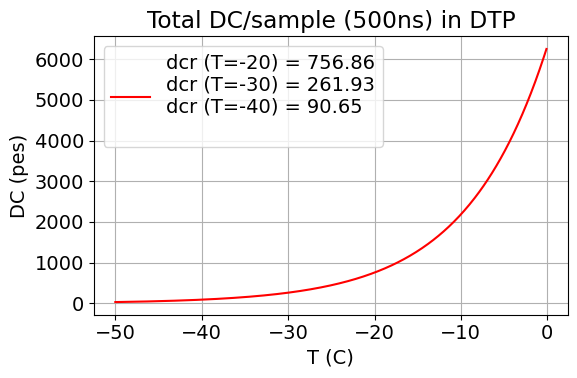

In [53]:
plotxy(tt, dc,  "T (C)", "DC (pes)", "Total DC/sample (500ns) in DTP",
      label=l1+l2+l3)

In [55]:
hdtp = pn.DTPDetector(hdel, hdxe, dtp, eff_grid=0.9, sampling=500*ns, tempC=-40)
print(hdtp)
print(f"Primary scintillation 511 keV detected = {hdtp.tpcel.scintillation_photons(511 * keV)* hdtp.efficiency_s1:.2e}")


        gas pressure  =   20.00 bar
        gas density   =    0.12 g/cm3
        gas mass      = 1039.51  kg

        Dimensions(Cylinder)  = 
        Cylinder: radius =1100.0 mm, length = 2200.0 mm
        

        Light efficiency (s1) = 3.56 %
        Light efficiency (s2) = 13.50 %
        SiPM PDE          = 0.30
        SiPM size         = 10.00 mm
        Sampling S1       = 500.00 ns

        Primary scintillation Krypton          = 1.06e+03
        EL photons Krypton                     = 1.78e+06
        Primary scintillation Qbb              = 6.27e+04
        EL photons Qbb                         = 1.06e+08

        Primary scintillation Krypton detected = 3.76e+01
        EL photons Krypton detected            = 2.40e+05
        Primary scintillation Qbb detected     = 2.23e+03
        EL photons Qbb detected                = 1.42e+07


        Number of DCR photons in the detector for:
         --operating temperature (-40.00 C)
         --sampling time of 500.00
    

## VUVHD requires cold gas operation

- The S1 signal detected for krypton is ~38 pes, and for Na22 (511 keV) 464 pes
- Thus, Kr cannot be observed at -40 C, but 511 keV from Na-22 can be observed with S/N~2.5. At higher temperatures Na22 cannot be observed.
- Thus, the minimum operating temperature for the SiPMs is -40 C.
- With a power dissipation of 150 W and the requirement to cool uniformly ~80k SiPMs to -40 C, the most realistic option is operation with cold gas.

## Pressure vs Density as a function of temperature 
- When considering cool gas one has to take into account two factors. The curves of density versus pressure for a given temperature, and the pressure at which the gas becomes liquid for a given temperature.
- At T = -50 C, gas becomes liquid above 10 bar. At 10 bar the density is 80 kg/m3, which is equivalent to a pressure of 14 bar at T = 20C.
- At T = -40 C, gas becomes liquid above 15 bar. At 15 bar the density is 126 kg/m3 which is equivalent to a pressure of 20 bar at T=20C. The gain in mass is 60 %
- In exchange, at T = -40 C one has 12.5 % more DC than a -50. Taking into account both effects favours cooling at -40 C.

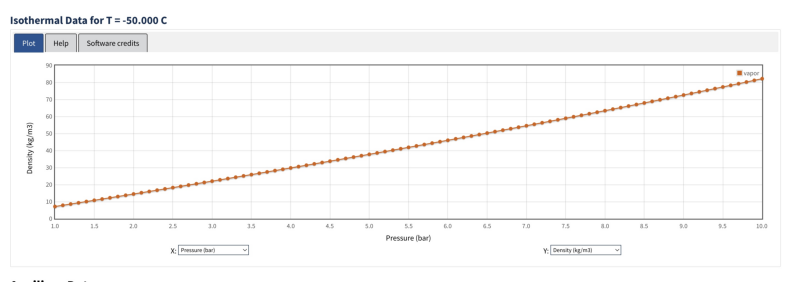

In [9]:
img = mpimg.imread('xenon_p_vs_rho_minus_50.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


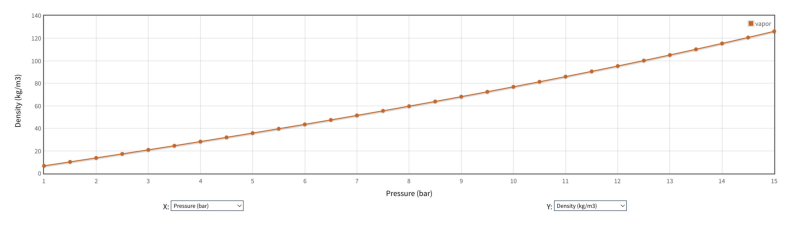

In [10]:
img = mpimg.imread('xenon_p_vs_rho_minus_40.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [21]:
u = kHz/mm2
dcm40 =pn.dc_mm2(-40) / u
dcm50 =pn.dc_mm2(-50) /u
print(f"DC/mm2 of Silicon at -40 C = {dcm40:.2g} kHz/mm2")
print(f"DC/mm2 of Silicon at -50 C = {dcm50:.2g} kHz/mm2")
print(f"DC ratio -40/-50 = {dcm40/dcm50}")
print(f"Mass ratio -40/-50 = {pn.rhoXe['xe_15m40'][1]/pn.rhoXe['xe_10m50'][1]}")

DC/mm2 of Silicon at -40 C = 0.048 kHz/mm2
DC/mm2 of Silicon at -50 C = 0.017 kHz/mm2
DC ratio -40/-50 = 2.889512931355543
Mass ratio -40/-50 = 1.5749999999999997


## Cost of the DTP
- Cost of the SiPMs (estimation from Hamamatsu offer) (2.96 €/mm2). This is a total cost of 22.5 M€ for both planes.
- Cost of the electronics and DAQ (20 €/channel) (1.5 M€)

In [57]:
sipm_6x6_4x4 = 223 #e
sipm_6x6_4x4_units = 16
sipm_6x6_cost = sipm_6x6_4x4/sipm_6x6_4x4_units
sipm_cost_mm2 = sipm_6x6_cost/36
print(f"Hamamatsu: cost SiPMs 6x6  per channel = {sipm_6x6_cost:.2f}, per mm^2 = {sipm_cost_mm2:.2f}")

sipm_6x6_4x4 = 1705 #e
sipm_6x6_4x4_units = 16
sipm_6x6_cost = sipm_6x6_4x4/sipm_6x6_4x4_units
sipm_vuv_cost_mm2 = sipm_6x6_cost/36
print(f"Hamamatsu: cost VUV SiPMs 6x6  per channel = {sipm_6x6_cost:.2f}, per mm^2 = {sipm_vuv_cost_mm2:.2f}")
print(f"Ratio VUV/Blue = {sipm_vuv_cost_mm2/sipm_cost_mm2}")

Hamamatsu: cost SiPMs 6x6  per channel = 13.94, per mm^2 = 0.39
Hamamatsu: cost VUV SiPMs 6x6  per channel = 106.56, per mm^2 = 2.96
Ratio VUV/Blue = 7.645739910313901


In [58]:
print(f"cost of DTP silicon (2 planes) {2 * sipm_vuv_cost_mm2* hdtp.dtp.area/mm2:.2e} €")
print(f"cost of DTP electronics) {2 * 20* hdtp.dtp.n_sipm:.2e} €")

cost of DTP silicon (2 planes) 2.25e+07 €
cost of DTP electronics) 1.52e+06 €


## DTP with partial coverage
- Consider for example SiPMs of 6 x 6 mm$^2$ at a pitch of 10 mm (36 % coverage). 
- Corrections to energy resolution to be studied. 
- Enough light to see S1 for Na22 and above (no S1 from Krypton)
- Cost reduced to ~8M€ (+ 1.5 M€ for electronics).


In [68]:
dtp2 = pn.DTP(vsipm, Rg, 0.36)
dtp2


        DTP: Fill factor = 0.36
        area = 3.8e+06 mm2, number of SiPMs = 3.8e+04
        SiPMs: 
        sensor =s10x10, size = 10.0 mm, PDE = 0.3
        DCR per u.a. (tC = 20C) = 2.8e+04 Hz/mm2;
        DCR per u.a time window (tC = 20C, t=500 ns) = 0.014 cs/mm2;
        
        DCR  (tC = 20C) = 3.8e+10 Hz;
        DCR  time window (tC = 20C, t=500 ns) = 1.9e+04 counts;
        
        

In [75]:
hdtp2 = pn.DTPDetector(hdel, hdxe, dtp2, eff_grid=0.9, sampling=500*ns, tempC=-40)
print(hdtp2)
s1511d = hdtp2.tpcel.scintillation_photons(511 * keV)* hdtp2.efficiency_s1 *0.36
print(f"Primary scintillation 511 keV detected = {s1511d:.2e}")


        gas pressure  =   20.00 bar
        gas density   =    0.12 g/cm3
        gas mass      = 1039.51  kg

        Dimensions(Cylinder)  = 
        Cylinder: radius =1100.0 mm, length = 2200.0 mm
        

        Light efficiency (s1) = 3.56 %
        Light efficiency (s2) = 13.50 %
        SiPM PDE          = 0.30
        SiPM size         = 10.00 mm
        Sampling S1       = 500.00 ns

        Primary scintillation Krypton          = 1.06e+03
        EL photons Krypton                     = 1.78e+06
        Primary scintillation Qbb              = 6.27e+04
        EL photons Qbb                         = 1.06e+08

        Primary scintillation Krypton detected = 1.36e+01
        EL photons Krypton detected            = 8.66e+04
        Primary scintillation Qbb detected     = 8.03e+02
        EL photons Qbb detected                = 5.13e+06


        Number of DCR photons in the detector for:
         --operating temperature (-40.00 C)
         --sampling time of 500.00
    

In [60]:
print(f"cost of DTP silicon (2 planes, f=0.36) {2 * 0.36* sipm_vuv_cost_mm2* hdtp.dtp.area/mm2:.2e} €")
print(f"cost of DTP electronics) {2 * 20* hdtp.dtp.n_sipm:.2e} €")

cost of DTP silicon (2 planes, f=0.36) 8.10e+06 €
cost of DTP electronics) 1.52e+06 €


## Cost of the Sparse (Blue) Tracking Plane
- For reference, the sparse tracking plane (STP) using blue SiPMs coated with TPB requires 100 timess less silicon area, than the fully tiled DTP, uses cheaper SiPMs and requires cheaper electronics (~10 €/channel).
- The cost of the SiPMs is reduced to ~30 k€
- The cost of the electronics becomes dominant ~700 k€
- The total cost is <1 M€ 

In [107]:
print(f"cost of STP silicon (2 planes, f=0.1) {2 * 0.01* sipm_cost_mm2* hdtp.dtp.area/mm2:.2e} €")
print(f"cost of DTP electronics) {2 * 10* hdtp.dtp.n_sipm:.2e} €")

cost of STP silicon (2 planes, f=0.1) 2.94e+04 €
cost of DTP electronics) 7.60e+05 €


## DTP Requirements and implications for the ASIC
- Observe S1 from Na-22 onwards. This requires extracting the full waveform (without ZS) from each one of the ~80K SiPMs. 
- Measure energy with excelent resolution from S2. This requires spe calibration). 
- At the same time S2 should not saturate the SiPMs.

## Measuring S1
- The pes/SiPM in the DTP is $\sim 4 \times 10^{-3}$. This means that most SiPMs will not observe S1, and those who have a signal will have a single pe. These cannot be distinguished from DC counts (zero in most SiPMs) until the full waveforms from all the SiPMs are added. Given the sparse signal, ZS appears unfeasible. 
- Each event will take 11.7 GB, posing significant challenges to DAQ and storage

In [78]:
nel511 = hdtp2.tpcel.scintillation_photons(511 * keV)* hdtp2.efficiency_s1 *0.36
nS1_511PerSiPM = nel511/dtp2.n_sipm
ndcrPerSiPM = 2*dtp2.dcr_sipm_per_time(-40, 500*ns)/dtp2.n_sipm
print(f"pes/SiPM for 511 keV S1 = {nS1_511PerSiPM:.2e}")
print(f"dcr/SiPM for 511 keV S1 = {ndcrPerSiPM:.2e}")

pes/SiPM for 511 keV S1 = 4.39e-03
dcr/SiPM for 511 keV S1 = 1.72e-03


In [83]:
data = 2400 * 64 * 2 * dtp2.n_sipm/1e+9
print(f"Data throughput = {data:.1f} GB")

Data throughput = 11.7 GB


## Dinamic range

## Interlude: S2 in SiPMs.


For a pointlike, isotropic source of $N$ photons at distance $r$ from a detector of area $A$ (normal to the radial line), the **number of detected photons** is

$$
    N_{\text{hits}} \;=\; 
    N \,\frac{A}{4\pi \,r^2}.
$$

In [84]:
def nhits(N, A, r):
    return N * A /(4 * np.pi * r**2)
def adcrange(nbits):
    return 2**nbits -1

def maxpes(nbits, adctopes):
    return adcrange(nbits)/adctopes

## Dynamic range
- Kr is a point-like signal. After diffusion and passing through the grid, the signal is distributed in around 10 mus. Assuming we read each 0.5 mus, the signal per sample is
$8.7 \times 10^4/20 = 4350$ pes. Of these about 124 pes are detected by the SiPM receiving the maximum signal (here I am assuming 6 x 6 mm2). If we want a dynamic range from 1 pes (needed for S1) and 124 pes (needed for S2 Kr), we need a 12 bit ADC (with a maximum of 20 ADC counts per pes, which is rather limit when we want to detect comfortably 1 pes). 
- On the other hand, the blobs of a double electron have tipically 300 keV of energy, or 6 times the energy of the krypton. This will saturate even a 13 bits ADC. 

In [100]:
nkR = 8.7e+4/20
nhkr = nhits(nkR, 36, 10)
print(f"pes in SiPM for kR = {nhkr:.1f}")
print(f"pes in SiPM for Qbb blob = {6*nhkr:.1f}")
print(f"maxpes for 12 bit ADC = {maxpes(11, 20):.1f}")
print(f"maxpes for 12 bit ADC = {maxpes(12, 20):.1f}")
print(f"maxpes for 13 bit ADC = {maxpes(13, 20):.1f}")

pes in SiPM for kR = 124.6
pes in SiPM for blob = 747.7
maxpes for 12 bit ADC = 102.3
maxpes for 12 bit ADC = 204.8
maxpes for 13 bit ADC = 409.6


## Summary: VUV HD
- The design constrain of not using TPB yields to a detector with two DTP instrumented with SiPMs. 
- The ideal scheme to measure S2 is a fully tiled DTP (as proposed by nEXO) which, however appears extremely challenging in terms of cost, power dissipation, ASIC impedance (due to the very high capacitance), dynamic range and throughput. 
- Some of these challenges are mitigated by considering smaller SiPMs (e.g., 6x6 mm2), but the impact on energy resolution need to be evaluated. The cost is reduced but still expensive (~10 M€). The problem of throughput and dynamic range still reamins. 
- Operation of the DTP requires very likely cold gas, given the large power dissipation needed and the requirement of cooling the SiPMs to -40 C. 
- Krypton S1 cannot be observed. Observation of 511 keV gammas from Na-22 is feasible but not trivial. 

## Veto on TPB and HD baseline
- The veto on TPB is a (debatable) requirement for NEXT-BOLD.
- I see no strong arguments to veto TPB in the case of NEXT-HD. On the contrary, as we will see, allowing TPB simplifies detector design and makes it very affordable. 
- The performance of HD in the search for bb0nu will depend on achieving the best possible energy resolution and topological signal, as well as reducing at maximum the radioactive budget. None of this requirements are affected by using or not TPB.
- TPB may be a problem for BOLD (to be demonstrated), but we are very far yet to have a feasible BOLD concept. HD design should not depend on a (potential) constrain of a future (and not guaranteed) detector.  


## HD Baseline
- The simplest configuration is to use a Sparse Tracking Plane (STP) similar to those already in operation in previous NEXT detectors and a Barrel of optical fibers (BFD). 

## The BFD
- Made of WLSF  of 1 mm, coated with TP, readout by SiPMs. 
- Detector has ~7000 fibers readout by ~70 bSiPMs of 10 x 10 mm2
- Enough light to detect Krypton and small DCR (can operate at -20C and still see the Krypton)
- Total cost under 100 k€

In [101]:
tpb = pn.WLS("TBP", 0.65)
print(tpb)
fwls = pn.FiberWLS(d = 1*mm, wls = tpb, qfib = 0.85, qptfe=0.98, ncore = 1.6, nclad1 = 1.49, nclad2 = 1.42, latt = 3.5*m)
print(f"fibers: {fwls}")
# for DC calculation consider that each fiber of 1 mm diameter need 1 mm2 of silicon to be read. Thus, one can count 
# 1 sipm per fiber. In a real detector, one will use larger SiPMs to bundle many fibers. 
s1mm = pn.SiPM(name='s1mm', xsize=1*mm, PDE = 0.5) 
print(s1mm)

WLS(name='TBP', qeff=0.65)
fibers: 
        diameter =1.0 mm, Q = 0.85, PTFE refl = 0.98
        ncore = 1.6, nclad1 =1.49, nclad2 =1.42
        Absoprtion prob at 450 nm     = 0.6692690255200586
        Trapping efficieny            = 0.05843750000000007
        Fiber coated with WLS         = TBP
        WLS QE                        = 0.65

    

        sensor =s1mm, size = 1.0 mm, PDE = 0.5
        DCR per u.a. (tC = 20C) = 2.8e+04 Hz/mm2;
        DCR per u.a time window (tC = 20C, t=500 ns) = 0.014 cs/mm2;
        


In [102]:
fdHD = pn.FiberDetector(hdel, hdxe, fwls, s1mm, eff_t=0.85, sampling= 500 * ns, tempC=-20)
fdHD


        gas pressure  =   20.00 bar
        gas density   =    0.12 g/cm3
        gas mass      = 1039.51  kg

        Dimensions(Cylinder)  = 
        Cylinder: radius =1100.0 mm, length = 2200.0 mm
        

        Fibers efficiency = 2.36 %
        of which: Transport = 3.23 % & attenuation = 73.03 %
        Total detection efficiency = 1.18 %
        SiPM PDE          = 0.50
        SiPM size         = 1.00 mm
        fiber size        = 1.00 mm
        Sampling S1       = 500.00 ns
        number of fibers  = 6912

        Primary scintillation Krypton          = 1.06e+03
        EL photons Krypton                     = 1.78e+06
        Primary scintillation Qbb              = 6.27e+04
        EL photons Qbb                         = 1.06e+08

        Primary scintillation Krypton detected = 1.25e+01
        EL photons Krypton detected            = 2.10e+04
        Primary scintillation Qbb detected     = 7.39e+02
        EL photons Qbb detected                = 1.24e+06

      

## The STP
- blue SiPM of 1x1 mm2, thus cost of SiPMs reduced by factor 7 (blue to VUV) x 36 (area of silicon) = 252
- Area per SiPM is 36 times smaller than in DTP. Can observe spe, not saturating S2 with 10 bit ADC. ASIC much simplified.
- Does not need to measure S1, thus ZS is possible. Throughput reduced by a large factor.
- Small SiPMs, small capacitance, 10 bit ADC: Much reduced cost of electronics, simplicity and less power dissipation. 
- No cooling complications

In [105]:
nkR = 8.7e+4/20
nhkr = nhits(nkR, 1, 10)
print(f"pes in SiPM for kR = {nhkr:.1f}")
print(f"pes in SiPM for Qbb blob = {6*nhkr:.1f}")
print(f"maxpes for 12 bit ADC = {maxpes(10, 20):.1f}")

pes in SiPM for kR = 3.5
pes in SiPM for Qbb blob = 20.8
maxpes for 12 bit ADC = 51.1


## DTP for HD (Baseline)?
- Does it make sense to build a DTP for HD baseline?
- Assumig that S1 is measured by BFD cooling is not necessary, since S2 is measured with a finite number of SiPMs and is a much larger signal than DC.
- If S1 is not measured, ZS becomes possible, thus solving the problem of throughput. 
- The problem of dynamic range remains, though. We need spe for calibration and we cannot afford saturation of S2. This may be solved by using dual channel ADCs.
- The cost is larger than the STP, but perhaps affordable. For example, a DTP with SiPMs of 6x6 mm2 would cost 2 M€. A fully tiled DTP would cost 5 M€.

In [106]:
print(f"cost of DTP silicon (2 planes, f=0.36) {2 * 0.36* sipm_cost_mm2* hdtp.dtp.area/mm2:.2e} €")
print(f"cost of DTP electronics) {2 * 15* hdtp.dtp.n_sipm:.2e} €")

cost of DTP silicon (2 planes, f=0.36) 1.06e+06 €
cost of DTP electronics) 1.14e+06 €


In [109]:
print(f"cost of DTP silicon (2 planes, f=0.36) {2 *  sipm_cost_mm2* hdtp.dtp.area/mm2:.2e} €")
print(f"cost of DTP electronics) {2 * 15* hdtp.dtp.n_sipm:.2e} €")

cost of DTP silicon (2 planes, f=0.36) 2.94e+06 €
cost of DTP electronics) 1.14e+06 €


## What would be the added value of DTP?
- Same performance in the tracking function than STP (determined by pitch, ~10 mm)
- Will provide an additional measurement of the energy, with different corrections (systematics) than BFD.
- If energy resolution with a DTP (and in particular with a DTP of 36%) is at least as good as that achieved by the BFD, then the physics argument may is compelling. Energy resolution is one parameter where we have marging for improvements.  


## Summary
- The "no TPB" restriction imposes very hard requirements on our detector and increase the cost of the system by a very large factor. The current exercise reveals that we must have a very compelling argument to impose the TPB veto. 
- HD Baseline seems sound enough for a detector whose physics goals are to achieve a sensitivity of 10$^{27}$ y in $\beta\beta0\nu$. HDB may operate with a STP or a DTP. 

## A path forward towards HD : HD-DEMO
- Test the performance of BFD, STP and DTP in HD-DEMO. The prototype is large enough to provide a good measurement of energy and tracking in the double escape peak of Tl, as well as a full energy calibration, from Kr to Tl. 
- HD-DEMO is being prepared to operate with a STP and standard (NEXT-White) electronics. The first phase of HD-DEMO operation (~2025 and 2026) would asess the performance of the simplest configuration.
- During HD-Demo phase I, we should build a DTP with the goal of operating it in 2027.Operation of the DTP in HD-DEMO would permit us to assess its merits concerning enery resolution.



## A path forward towards HD : N100-U2
- Get the pun? U2 means "upgrade 2" (with respect to model 1, e.g, next-100), but also, sends a message. If we are going to succeed as a collaboration, everybody should get involved in U2. You too! 
- U2 will implement a BFD and new electronics, including a new ASIC. The current plan is to leave NEXT-100 STP. But this is a great opportunity for the groups interested in the DTP to join the effort. Why not build a DTP for U2? New collaborators would be more than welcomed to join the DTP effort.
- Given that the cathode is free, there may be even the possibility to add a camera to test CRAB reconstruction of tracks at large scale. 
- The time-frame of U2 could be 3-4 years (e.g, operation of NEXT-100 until the end of 2027, upgrade in 2028, operation of upgrade in 2029), well timed with the potential availability of xenon from KZ. 


## HD White paper.
- A CDR (or pre-CDR) may be premature today, but we should produce a document that acts both as a roadmap and as an advertising brochure for potential collaborators.
- We could write a White Paper describing (with more detail than in the EOI) the basic elements of HD (this include not-so-sexy things suchs as grids of 2 m and gas system), as well as HD-DEMO and NEXT-100U2. 